## Youtube Data Analysis

In this notebook, I have a dataset of user comments for youtube videos related to animals or pets. I will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the highest fraction of cat or dog owner users who I can recommend video creators to.

Step 1: Identify cat And dog owners and find the users who are cat and/or dog owners.

Step 2: Build and evaluate classifiers for the cat and dog owners and measure the performance of the classifiers.

Step 3: Apply the best classifier to all the users in the dataset. Estimate the fraction of all users who are cat/dog owners.

Step 4: Extract insights about cat and dog owners through finding topics important to cat and dog owners.

Step 5: Identify creators with pet owners in the audience. Find creators whose video commented by the most cat and/or dog owners. In other words, creators with the highest statistically significant percentages of cat and/or dog owners.

## Step 1: Identify Cat And Dog Owners and find the users who are cat and/or dog owners.

#### 1.1. Data Exploration and Cleaning

In [5]:
df_clean=spark.read.csv("/FileStore/tables/animals_comments.csv",inferSchema=True,header=True)
df_clean.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

In [6]:
df_clean.count() 

Out[ 2 ]: 5820035

In [7]:
df_clean = df_clean.na.drop(subset=["comment"])
df_clean.count()

Out[ 3 ]: 5818984

In [8]:
df_clean.show()

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟|
Hope For Paws - O...|2911.0| That mother cat l...|
Hope For Paws - O...|2911.0| Its people like H...|
 Talking Kitty Cat|2911.0| steve: No wet foo...|
 Brave Wilderness|3224.0| Dont call this a ...|
 MaxluvsMya|3267.0| why are you alway...|
Rise Up Society F...|3372.0| Deb Tucker|
 The Dodo|3466.0| Thats a deer isnt...|
 Brave Wilderness|3466.0| there is no safe ...|
 Brave Wilderness|3466.0| Red before yellow...|
+--------------------+------+-------------------------------------+
only showing top 20 rows

In [9]:
# find user with preference of dog and cat
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# you can user your ways to extract the label

df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

# (large,small)=df_clean.filter(col('label')==1).randomSplit([0.99, 0.01],seed = 100)
# df_clean = small
df_clean.createOrReplaceTempView('iden_owner')

In [10]:
%sql

Select label,count(*)
From iden_owner
Group by 1


label,count(1)
1,40225
0,5778759


In [11]:
df_clean.show()

+--------------------+------+-------------------------------------+-----+
 creator_name|userid| comment|label|
+--------------------+------+-------------------------------------+-----+
 Doug The Pug| 87.0| I shared this to ...| 0|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| 0|
 bulletproof| 530.0| stop saying get e...| 0|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| 0|
 ojatro|1031.0| I wanna see what ...| 0|
 Tingle Triggers|1212.0| Well shit now Im ...| 0|
Hope For Paws - O...|1806.0| when I saw the en...| 0|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0|
 Brian Barczyk|2698.0| Call the teddy Larry| 0|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟| 0|
Hope For Paws - O...|2911.0| That mother cat l...| 0|
Hope For Paws - O...|2911.0| Its people like H...| 0|
 Talking Kitty Cat|2911.0| steve: No wet foo...| 0|
 Brave Wilderness|3224.0| Dont call this a ...| 0|
 MaxluvsMya|3267.0| why are you alway...| 0|
Rise Up Society F...|3372.0| Deb Tucker| 0|
 The Dodo|3466.0| Thats a deer isnt...| 0|
 Brave Wilderness|3466.0| there is no safe ...| 0|
 Brave Wilderness|3466.0| Red before yellow...| 0|
+--------------------+------+-------------------------------------+-----+
only showing top 20 rows

#### 1.2 Data preprocessing including numeric vector feature generation and obtain training and test data

In [13]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")

remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# countvec = CountVectorizer(inputCol='filtered', outputCol='features')
word2Vec = Word2Vec(inputCol="filtered", outputCol="features",vectorSize=20)

In [14]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, remover, word2Vec])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_clean)
dataset = pipelineFit.transform(df_clean)

In [15]:
cate_num = dataset.groupBy("label").count()
cate_num.show()

+-----+-------+
label| count|
+-----+-------+
 1| 40225|
 0|5778759|
+-----+-------+

In [16]:
(label0_train,label0_test)=dataset.filter(col('label')==1).randomSplit([0.7, 0.3],seed = 100)
(label1_train, label1_ex)=dataset.filter(col('label')==0).randomSplit([0.005, 0.995],seed = 100)
(label1_test, label1_ex2)=label1_ex.randomSplit([0.002, 0.998],seed = 100)

In [17]:
trainingData = label0_train.union(label1_train)
testData=label0_test.union(label1_test)

In [18]:
display(trainingData.groupBy("label").count())
# view training data's number of each label

label,count
1,28288
0,28617


In [19]:
display(testData.groupBy("label").count())
# view test data's number of each label

label,count
1,11937
0,11402


In [20]:
# print("Dataset Count: " + str(dataset.count()))
# print("Training Dataset Count: " + str(trainingData.count()))
# print("Test Dataset Count: " + str(testData.count()))

## Step 2: Build And tune Classifiers for the cat and dog owners and measure the performance of the classifiers.

#### 2.1 Logistic Regression

In [23]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=8, regParam=0.05, elasticNetParam=0.8)
lrModel = lr.fit(trainingData)

print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (20,[2,3,4,5,8,9,11,16,17,18],[-0.637533510665,0.822876035946,0.0898488903943,3.2371350475,1.10421491543,-1.41716540637,-0.850681725766,0.345973383937,1.75914350751,-0.0991986210241])
Intercept: -0.9605457505225621

##### Parameter Tuning and K-fold cross-validation

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam,[0.01,0.05,0.1,0.2])\
            .addGrid(lr.maxIter,[8,10,12,14])\
            .build()
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed = 42)
cvModel = crossval.fit(trainingData)


/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [26]:
# best_model = cvModel.bestModel
# best_model.extractParamMap()

#### 2.2 Random Forest

In [28]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', seed=42)
# rfModel = rf.fit(trainingData)
# prediction = rfModel.transform(trainingData)

# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# evaluator = BinaryClassificationEvaluator()
# evaluator.evaluate(prediction)

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees,[50,100])\
            .addGrid(rf.maxDepth,[6,8,10])\
            .build()
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed = 42)
cv_rfModel = crossval.fit(trainingData)


/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [30]:
# best_model = cv_rfModel.bestModel
# best_model.extractParamMap()

#### 2.3 Gradient boosting

In [32]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='label', featuresCol='features', seed=42)

paramGrid = ParamGridBuilder()\
            .addGrid(gbt.stepSize,[0.05,0.1])\
            .addGrid(gbt.maxIter,[6,8,10])\
            .addGrid(gbt.maxDepth,[5,6])\
            .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                          seed = 42)
cv_gbtModel = crossval.fit(trainingData)

#### 2.4 Get the best model with best hyper-parameter

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

rf_predict = cv_rfModel.transform(testData)
evaluator.evaluate(rf_predict)

Out[ 16 ]: 0.9335917252061099

In [35]:
lr_predict = cvModel.transform(testData)
evaluator.evaluate(lr_predict)

Out[ 20 ]: 0.8804782635292607

In [36]:
gbt_predict = cv_gbtModel.transform(testData)
evaluator.evaluate(gbt_predict)

Out[ 21 ]: 0.9211738777326834

In [37]:
rf_predict.createOrReplaceTempView('rf')

In [38]:
%sql

Select label,prediction,count(*)
From rf
Where label!=prediction
Group by 1,2



label,prediction,count(1)
1,0.0,1043
0,1.0,2079


## Step 3: Apply the best classifier to all the users in the dataset. Estimate the fraction of all users who are cat/dog owners.

#### 3.1 Classify All The Users

In [41]:
prediction = cv_rfModel.transform(dataset)

In [42]:
prediction.createOrReplaceTempView('predict')

In [43]:
%sql

Select prediction,count(*)
From predict
Group by 1

-- have a look at classification for all data

prediction,count(1)
0.0,4746142
1.0,1072842


#### 3.2 Get fraction of pet owner users

In [45]:
%sql

with total as
(
Select count(*) as total
From predict
),
par as
(
Select prediction,count(*) as num
From predict
Group by 1
)

Select prediction, num, num/total as frac
From par 
cross join total

-- have a look at total fraction

prediction,num,frac
0.0,4750518,0.8163827224821377
1.0,1068466,0.18361727751786222


## Step 4: Extract insights about cat and dog owners through finding topics important to cat and dog owners.

#### 4.1 Use CountVectorizer to extract features instead of word2Vec in order to visualize words in each topic

In [48]:
label1 = prediction.filter(col('prediction')==1)

In [49]:
from nltk.stem.porter import *

# Instantiate stemmer object
stemmer = PorterStemmer()

# Create stemmer python function
def stem(in_vec):
    out_vec = []
    for t in in_vec:
        t_stem = stemmer.stem(t)
        if len(t_stem) > 2:
            out_vec.append(t_stem)       
    return out_vec

# Create user defined function for stemming with return type Array<String>
from pyspark.sql.types import *
stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType()))

# Create new column with vectors containing the stemmed tokens 
label1 = label1.withColumn("stem_word", stemmer_udf("filtered"))

In [50]:
text1 = label1.select("stem_word").rdd.flatMap(lambda a: a.stem_word).countByValue()
wordfreq = sorted(text1.items(),key=lambda x:x[1],reverse=True)

Out[ 52 ]: [('dog', 264287),
 ('like', 194001),
 ('cat', 173170),
 ('love', 155042),
 ('get', 131788),
 ('one', 117036),
 ('look', 84034),
 ('video', 78908),
 ('cute', 76203),
 ('want', 74843),
 ('know', 68524),
 ('anim', 67473),
 ('dont', 65995),
 ('time', 63747),
 ('peopl', 62913),
 ('make', 58880),
 ('littl', 58206),
 ('see', 57910),
 ('think', 55890),
 ('good', 55607),
 ('got', 53382),
 ('much', 51931),
 ('year', 49651),
 ('hors', 48883),
 ('realli', 47678),
 ('thing', 46739),
 ('take', 46173),
 ('day', 44908),
 ('hope', 44733),
 ('thank', 44588),
 ('lol', 44575),
 ('need', 43287),
 ('babi', 42705),
 ('happi', 41491),
 ('kitten', 41343),
 ('pet', 40684),
 ('watch', 40437),
 ('old', 39633),
 ('even', 39225),
 ('help', 38716),
 ('puppi', 37297),
 ('give', 37180),
 ('guy', 36910),
 ('never', 36253),
 ('live', 35711),
 ('tri', 35640),
 ('feel', 35303),
 ('poor', 35145),
 ('say', 34977),
 ('life', 34558),
 ('well', 34512),
 ('care', 33776),
 ('back', 33686),
 ('still', 32804),
 ('way', 32635),
 ('home', 32541),
 ('also', 32528),
 ('eat', 32424),
 ('that', 30934),
 ('alway', 29547),
 ('food', 29436),
 ('she', 29369),
 ('name', 29332),
 ('better', 29171),
 ('ever', 29057),
 ('bad', 28995),
 ('best', 28733),
 ('mom', 28517),
 ('beauti', 28429),
 ('die', 28023),
 ('cant', 27638),
 ('girl', 26861),
 ('ive', 26820),
 ('work', 26639),
 ('keep', 26436),
 ('use', 26406),
 ('big', 26393),
 ('put', 26198),
 ('away', 26070),
 ('play', 26012),
 ('two', 25993),
 ('great', 25876),
 ('come', 25784),
 ('first', 25696),
 ('let', 25649),
 ('cri', 25181),
 ('wish', 24994),
 ('sad', 24934),
 ('around', 24408),
 ('friend', 24157),
 ('kitti', 23796),
 ('adopt', 23728),
 ('right', 23692),
 ('lot', 23671),
 ('everi', 23501),
 ('didnt', 23501),
 ('mani', 23202),
 ('owner', 23007),
 ('human', 22871),
 ('famili', 22726),
 ('new', 22081),
 ('bird', 21288),
 ('sweet', 21041),
 ('rescu', 21038),
 ('pleas', 21019),
 ('hous', 20702),
 ('wonder', 20324),
 ('train', 20278),
 ('ador', 20187),
 ('made', 19981),
 ('person', 19964),
 ('kill', 19935),
 ('start', 19810),
 ('boy', 19554),
 ('kid', 19410),
 ('someon', 19274),
 ('someth', 19175),
 ('huski', 18671),
 ('omg', 18628),
 ('said', 18506),
 ('long', 18418),
 ('save', 18095),
 ('doesnt', 18051),
 ('stop', 18022),
 ('sure', 17933),
 ('call', 17738),
 ('happen', 17622),
 ('breed', 17338),
 ('walk', 17266),
 ('run', 17250),
 ('month', 17196),
 ('mean', 17097),
 ('feed', 16898),
 ('thought', 16785),
 ('find', 16779),
 ('show', 16689),
 ('treat', 16675),
 ('fuck', 16519),
 ('heart', 16445),
 ('tell', 16387),
 ('seem', 16220),
 ('last', 16000),
 ('anoth', 15933),
 ('end', 15838),
 ('glad', 15752),
 ('your', 15668),
 ('amaz', 15542),
 ('vet', 15505),
 ('kind', 15420),
 ('week', 15370),
 ('man', 15368),
 ('sorri', 15247),
 ('theyr', 15054),
 ('miss', 14934),
 ('hard', 14791),
 ('bit', 14628),
 ('found', 14527),
 ('face', 14422),
 ('though', 14298),
 ('sound', 14271),
 ('max', 14203),
 ('nice', 14092),
 ('ago', 14075),
 ('eye', 14069),
 ('talk', 14037),
 ('seen', 13877),
 ('leav', 13752),
 ('gohan', 13723),
 ('sinc', 13670),
 ('mayb', 13619),
 ('world', 13517),
 ('actual', 13447),
 ('black', 13385),
 ('hate', 13361),
 ('saw', 13089),
 ('place', 13073),
 ('went', 12842),
 ('rabbit', 12806),
 ('probabl', 12788),
 ('bunni', 12762),
 ('dad', 12586),
 ('pretti', 12521),
 ('hand', 12352),
 ('head', 12209),
 ('hamster', 11970),
 ('mother', 11949),
 ('hurt', 11945),
 ('funni', 11939),
 ('cage', 11916),
 ('abus', 11857),
 ('sleep', 11563),
 ('fox', 11439),
 ('took', 11389),
 ('almost', 11371),
 ('scare', 11292),
 ('channel', 11292),
 ('pit', 11255),
 ('god', 11200),
 ('caus', 11195),
 ('must', 11082),
 ('anyth', 11010),
 ('bite', 11006),
 ('leg', 10872),
 ('fight', 10852),
 ('stay', 10714),
 ('done', 10705),
 ('everyth', 10604),
 ('robin', 10556),
 ('bull', 10537),
 ('small', 10430),
 ('attack', 10414),
 ('move', 10387),
 ('toy', 10342),
 ('anyon', 10330),
 ('snake', 10314),
 ('without', 10168),
 ('everyon', 10123),
 ('lost', 100

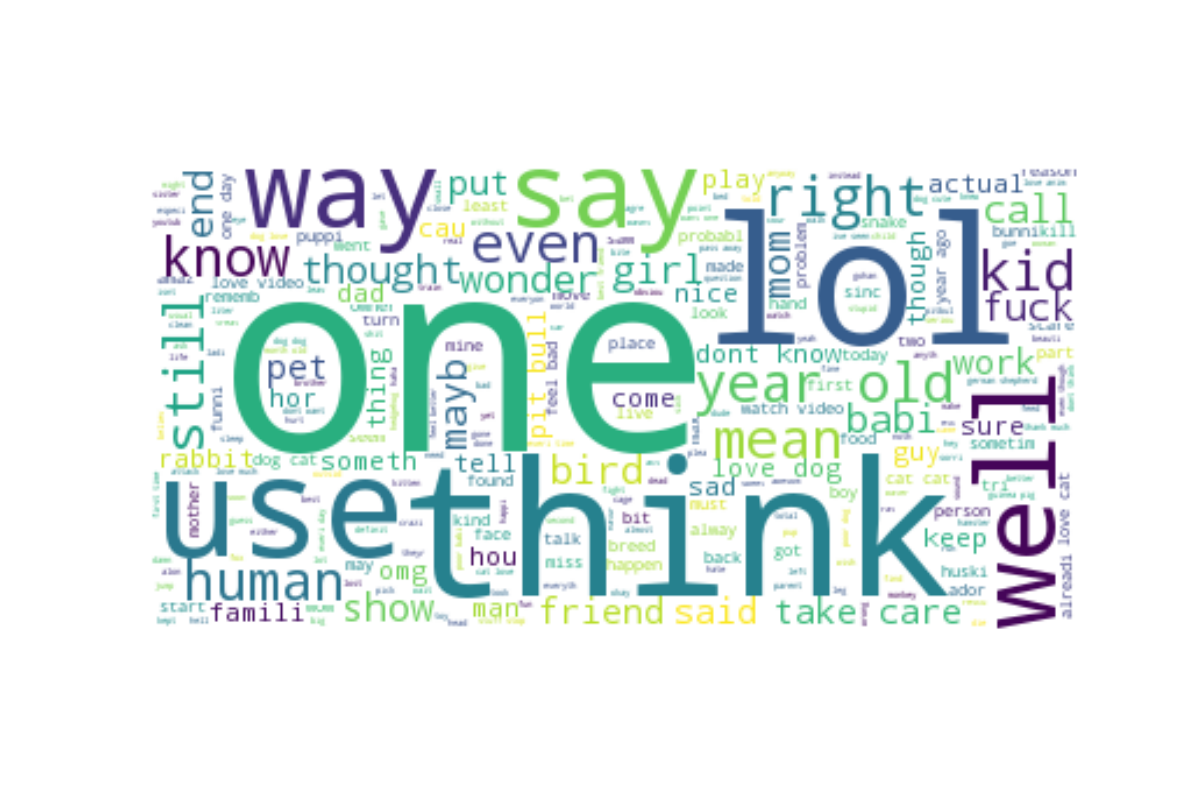

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = label1.select("stem_word").collect()
stopwords = ['cat','dog','like','love','get','got','one','look','know','want','kitti','puppi','lol','dont','never','much','realli','see','also','peopl','need','thing','think','even']

# words = " ".join([(k + " ")*v for k,v in text1.items()])
words = " ".join([word for row in text for word in row[0]])

wcloud = WordCloud(stopwords=stopwords,max_words=1000, background_color="white").generate(words)

fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")
display(fig)

In [52]:
from pyspark.ml.feature import CountVectorizer

countvec = CountVectorizer(inputCol='stem_word', outputCol='vectors')
count_model = countvec.fit(label1)
train = count_model.transform(label1)

#### 4.2 extract topics of pet owner users via LDA clustering

In [54]:
from pyspark.ml.clustering import LDA

lda = LDA(maxIter=10,k=20,featuresCol='vectors',seed=2)
model = lda.fit(train)

In [55]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

vocab = count_model.vocabulary

def trans(x):
  return [vocab[i] for i in x]

idx2word = udf(lambda y: trans(y), ArrayType(StringType()))

In [56]:
topics = model.describeTopics(10).withColumn("terms",idx2word("termIndices"))
display(topics.select("topic","terms","termWeights"))

topic,terms,termWeights
0,"List(like, dog, hors, love, video, get, want, one, know, see)","List(0.0033091898820267365, 0.002227881075900661, 0.0015083625153508185, 0.001463258571768888, 0.0013827503060440712, 0.001207560775041094, 0.0011614331103930843, 0.0011400944964031707, 0.0010795313219905654, 9.426601861864572E-4)"
1,"List(like, one, dog, know, look, need, dont, cute, good, realli)","List(0.001385906830760741, 0.0012692431549632763, 8.102378721927004E-4, 8.098012640498103E-4, 6.857011725794759E-4, 5.901997827932992E-4, 5.78547414122974E-4, 4.7094147271345134E-4, 4.034798213501735E-4, 4.034429426314212E-4)"
2,"List(cat, like, one, fox, never, video, hors, kid, time, year)","List(0.001751665852545002, 7.466277145489437E-4, 4.3196096060006667E-4, 3.914114140408701E-4, 3.9003991841978815E-4, 3.8112056596183744E-4, 3.3969490704808614E-4, 3.112283026168148E-4, 2.6655983966099794E-4, 2.6040027365030135E-4)"
3,"List(kitten, get, like, poor, cat, want, dog, girl, gohan, cute)","List(0.00592415291701186, 0.004322138288995299, 0.0034617114594601675, 0.003197226092501597, 0.0029794199622810895, 0.0026559752256761263, 0.002598950308347045, 0.002400906258739641, 0.002372001319574517, 0.0023654848961232318)"
4,"List(dog, get, video, love, one, year, make, cute, boy, old)","List(0.0012584139781495502, 0.0011528235245813433, 7.809894873150376E-4, 7.277477897842005E-4, 6.340078099947019E-4, 5.569135764880212E-4, 4.851762995876737E-4, 4.8443211556885296E-4, 4.740538386993936E-4, 4.530990365629132E-4)"
5,"List(cat, like, hors, dog, think, look, video, one, got, get)","List(0.0012250386294659185, 0.0011264974392771764, 9.525434689214974E-4, 9.469011975464943E-4, 8.941968287898861E-4, 8.472496929247292E-4, 7.945073257834197E-4, 5.598113819236385E-4, 5.491582859053207E-4, 5.225707370378512E-4)"
6,"List(want, look, dog, know, video, time, one, like, cute, love)","List(6.87844945688612E-4, 5.894005953406539E-4, 4.4383979820023493E-4, 3.857261838805142E-4, 3.650834130026694E-4, 3.5393440729811405E-4, 3.3601432125615876E-4, 3.245473816747573E-4, 3.0279703497276464E-4, 2.923958835129328E-4)"
7,"List(cat, one, like, love, much, dog, realli, dont, old, know)","List(0.003303149434829605, 0.001520840928271244, 0.0012823405736234117, 0.0010832704423442965, 0.00101354097631234, 9.164107942040965E-4, 8.645933005852393E-4, 8.146472384619601E-4, 7.801075885485768E-4, 7.252400163212429E-4)"
8,"List(like, get, cat, love, look, lol, one, time, good, think)","List(0.0040764871234502615, 0.001538843605339142, 0.0012668044387171415, 0.0010788924956998812, 0.0010226006728222133, 0.0010199980976306105, 9.478302332607673E-4, 8.90431067850781E-4, 8.340081750545267E-4, 6.969164380498846E-4)"
9,"List(like, dog, cat, look, love, get, doberman, babi, much, want)","List(0.005221540067281018, 0.004267297910377205, 0.003981446034909807, 0.0038372761690032143, 0.0026966392900533783, 0.0019306096053963821, 0.001744432105916552, 0.001284859676017009, 0.0011551944095612434, 0.0010341647695520683)"


In [57]:
from pyspark.sql.functions import explode, arrays_zip

topics_words = topics.withColumn("termWithProb", explode(arrays_zip("terms", "termWeights")))
topics_words.createOrReplaceTempView("topics")


In [58]:
%sql

Select topic, termWithProb["terms"] as term, termWithProb["termWeights"] as probability
From topics

-- get words in each topics with probability

topic,term,probability
0,like,0.0033091898820267365
0,dog,0.002227881075900661
0,hors,0.0015083625153508185
0,love,0.001463258571768888
0,video,0.0013827503060440712
0,get,0.001207560775041094
0,want,0.0011614331103930843
0,one,0.0011400944964031707
0,know,0.0010795313219905654
0,see,9.426601861864572E-4


In [59]:
%sql

Select termWithProb["terms"] as term, max(termWithProb["termWeights"]) as probability
From topics
Group by 1
Order by 2 Desc

term,probability
cat,0.028746394601080322
dog,0.020220704591039113
like,0.016063709903113812
love,0.012224043819751892
get,0.011244628523325601
one,0.009965835627474903
look,0.006841759751860303
video,0.0064957050094062285
know,0.006350413620455396
want,0.006323214920031772


## Step 5: Identify creators with pet owners in the audience. Find creators whose video commented by the most cat and/or dog owners. In other words, creators with the highest statistically significant percentages of cat and/or dog owners.

In [61]:

top = spark.sql(
      """Select creator_name, count(*) as pet_owner_num
      From predict
      Where prediction=1
      Group by 1
      Order by 2 DESC
      limit 20""")

display(top)


creator_name,pet_owner_num
The Dodo,102195
Brave Wilderness,69834
Taylor Nicole Dean,58609
Robin Seplut,54850
Brian Barczyk,41072
Hope For Paws - Official Rescue Channel,40053
Gohan The Husky,37097
Vet Ranch,31580
Gone to the Snow Dogs,25006
Cole & Marmalade,21630


In [62]:
%sql

with filter as 
  (Select creator_name, count(*) as num
  From predict
  Group by 1
  Having num>=10000
  ),
  part as 
  (Select pre.creator_name, prediction, count(*) as pet_owner_num
  From predict as pre
  Inner join filter as f on pre.creator_name=f.creator_name
  Group by 1,2
  Order by 1)

Select p.creator_name, pet_owner_num, pet_owner_num/num as fraction
From part as p
Inner join filter as f on p.creator_name=f.creator_name
Where p.prediction = 1
Order by 3 DESC



creator_name,pet_owner_num,fraction
Zak Georges Dog Training rEvolution,11849,0.6345865467009426
MaxluvsMya,7829,0.5283795640143079
Lennon The Bunny,5611,0.5221477759166201
Dogumentary TV,5809,0.48255524173450737
stacyvlogs,17925,0.4799453786012638
meow meow,7885,0.47631992267729856
Robin Seplut,55227,0.4738603310252516
Kitten Academy,9057,0.4722845074829223
Paws Channel,12188,0.4606546224204399
Cat Man Chris,5745,0.45175748997405046


#### 5. Analysis and Future work

## Summary

In this project, I dealt with 5.8 million comments on videos about pet on Youtube to do recommendation to pet owner users.  
1. I labelled comments which are from pet owner users (label 1) by keywords like "my dog", "my cat", "I have a kitty" and extracted around 40,000 label 1 data. Added 40,000 label 0 data and splitted them into train and test dataset.  
2. Built pipeline including tokenizer, stopword remover and word2Vec to transform comments to numeric vector features.
3. Trained classification models including Logistic Regression, Random Forest and Gradient Boosting and tuned their parameters via cross validation. Compared these classfication models and obtained the best performance model random forest with 93% accuracy. 
4. Applied random forest model to rest data to classify comments from pet owner users, which were around 18.4% among all.
5. Extracted main topic of comments from pet owner users, the most important words including "cat", "dog", "like", "cute" which didn't contain much useful information. I also tried added those words to stopwords, but still could not find interesting content words. This part needs further exploration.
6. Filtered out video creator with more than 10,000 comments, "Zak Georges Dog Training rEvolution", "MaxluvsMya", "Lennon The Bunny" are top 3 creator with highest fraction of commented by pet owner users. These creators can be recommended to users interested in pets.

## Future work
1. Identify pet owner users based on more information.
2. Explore other methods to extract significant topics for pet owner users to obtain useful information.